<a href="https://colab.research.google.com/github/RubenSierraSerrano/PracticaCapstone/blob/main/Capstone_GTSDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GRUPO B02**                                         
Paula Diz Diz
<br>Lucía de Angulo Pelayo
<br>Rubén Sierra Serrano

# Práctica Final - Capstone

## Introducción y motivación

<p align="justify">

El siguiente trabajo busca crear una red neuronal convolucional capaz de categorizar tipos de señales de tráfico, para ello emplearemos el dataset [***GTSDB - German Traffic Sign Detection Benchmark***](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) y constuiremos nuestra red con Keras.

<p align="justify">

Este trabajo puede ser empleado como punto de partida para el desarrollo de una IA capaz de conducir un vehículo de forma autónoma, dicha tecnología esta actualmente en desarrollo y tiene el potencial de revolucionar el sector automovilístico.

## Importación de librerías y del dataset en el entorno

Primero de todo, vamos a importar todas las librerías necesarias:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization, Dropout, Lambda, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from skimage.filters import rank
import skimage.morphology as morp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import random
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Vamos a borrar previamente las carpetas generadas:

In [2]:
!rm -rf GTSRB/
!rm -rf GTSRB_Final_Training_Images.zip

Vamos a descargar nuestro dataset:

In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2024-01-08 07:33:17--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  24.1MB/s    in 12s     

2024-01-08 07:33:30 (21.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



## Exploración del dataset

Cargamos nuestro dataset:

In [4]:
dataset_path = "GTSRB/Final_Training/Images"

# Función para cargar imágenes y etiquetas
def load_dataset(dataset_path):
    images = []
    labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".ppm"):
                    image_path = os.path.join(folder_path, file)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (32, 32))
                    images.append(image)
                    labels.append(int(folder))  # La etiqueta es el nombre de la carpeta

    return np.array(images), np.array(labels)

# Cargar el conjunto de datos
images, labels = load_dataset(dataset_path)

Vamos a visualizar un subconjunto de nuestros datos:

Total de imágenes en el conjunto de datos: 39209
Total de clases únicas en el conjunto de datos: 43


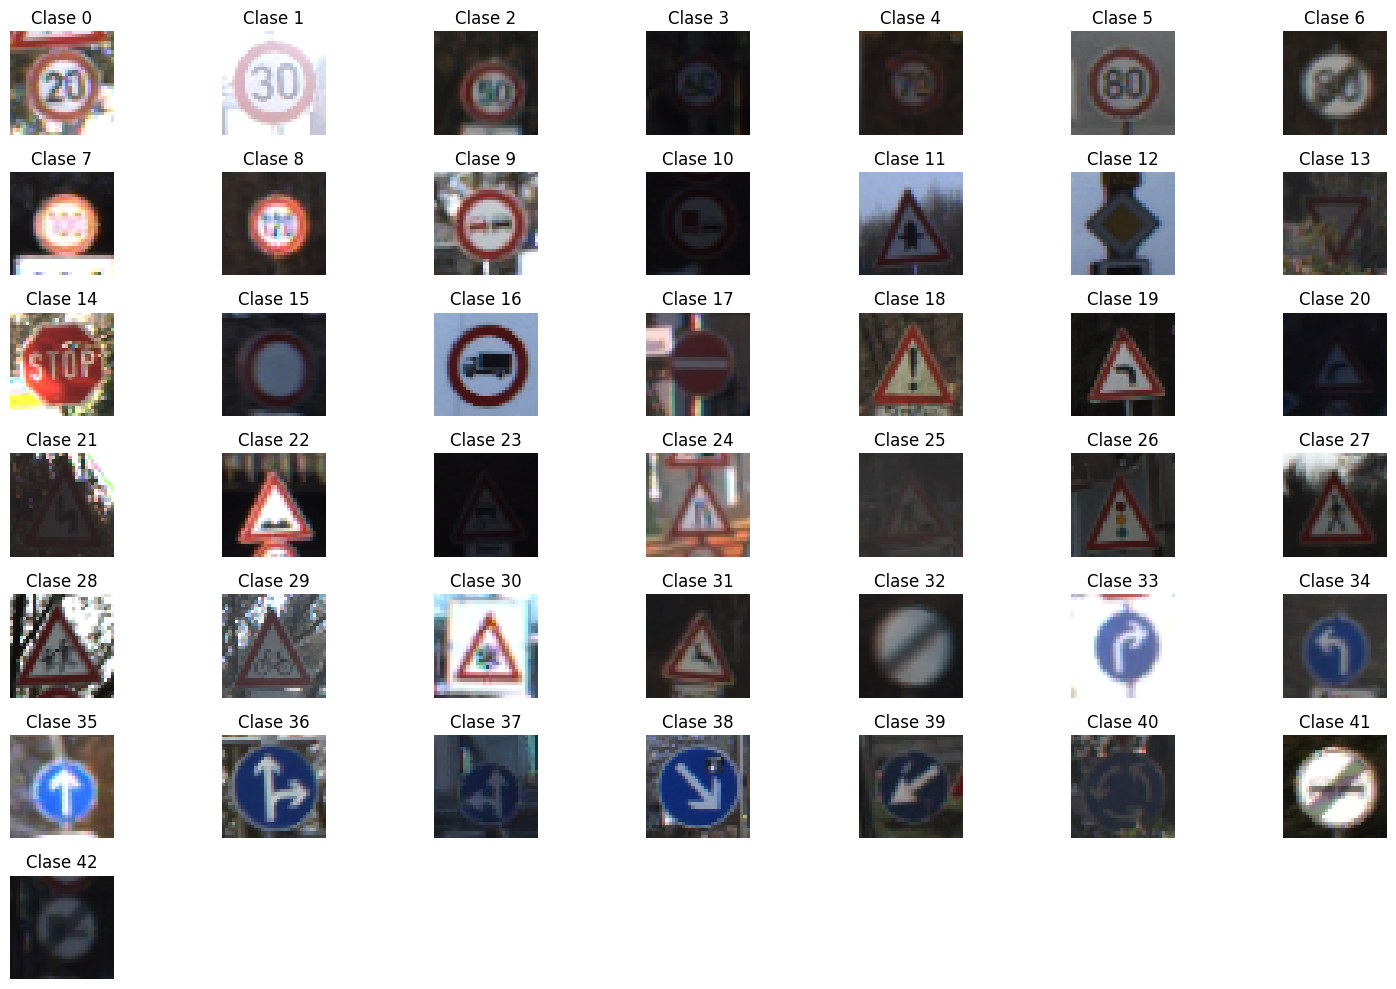

In [5]:
random.seed(42)
np.random.seed(42)
# Muestra la cantidad de imágenes totales
total_images = len(images)
print(f"Total de imágenes en el conjunto de datos: {total_images}")

# Muestra la cantidad de clases únicas
num_classes = len(np.unique(labels))
print(f"Total de clases únicas en el conjunto de datos: {num_classes}")

# Muestra algunas imágenes de ejemplo de cada clase
mosaic_size = 7
mosaic_rows = int(math.ceil(num_classes / mosaic_size))
mosaic_cols = mosaic_size

plt.figure(figsize=(15, 10))

for i in range(num_classes):
    class_samples = np.where(labels == i)[0]
    sample_image_index = random.choice(class_samples)
    sample_image = images[sample_image_index]

    plt.subplot(mosaic_rows, mosaic_cols, i + 1)
    plt.imshow(sample_image)
    plt.title(f"Clase {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Puede resultar interesante observar la distribución del número de muestras en cada clase:

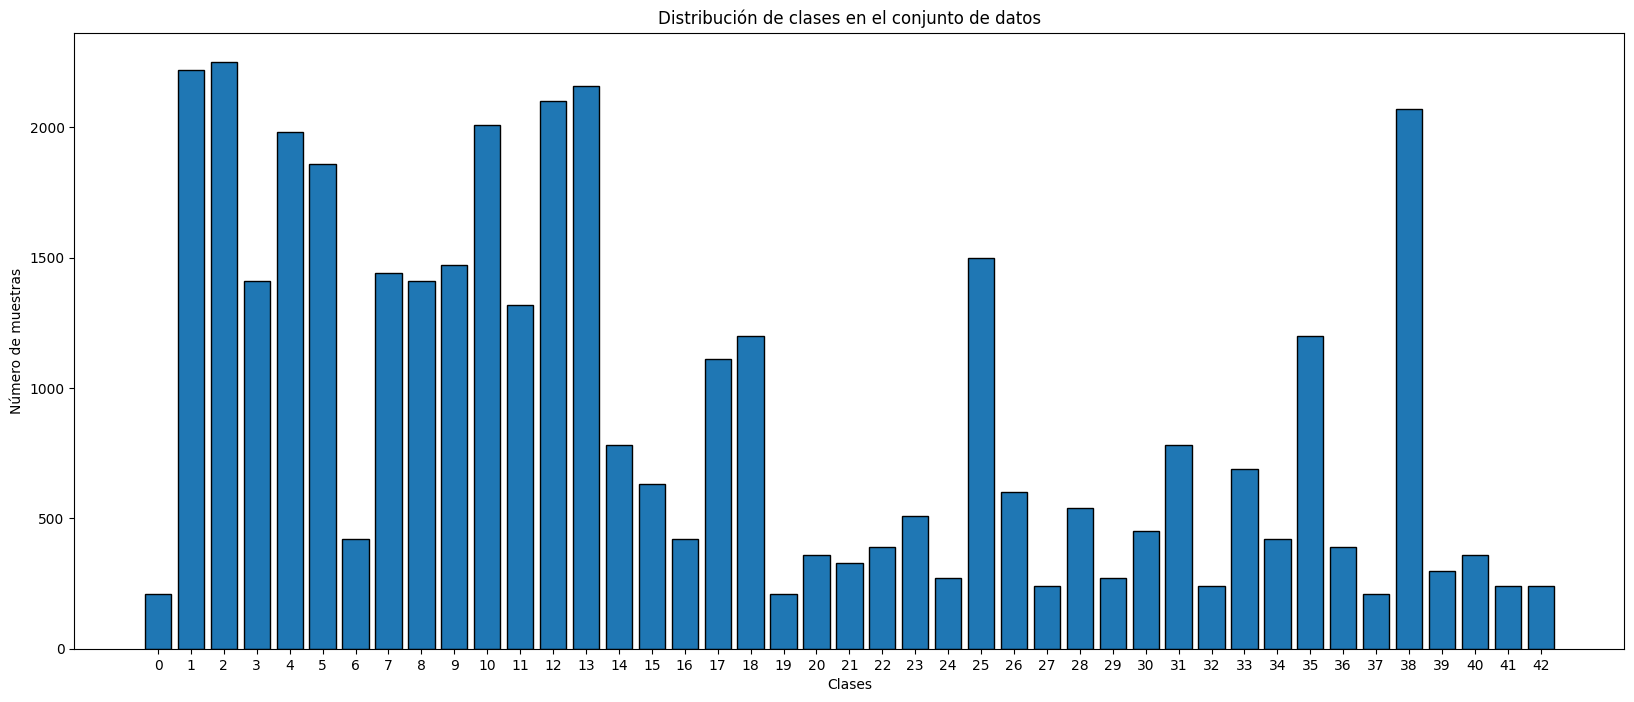

In [6]:
plt.figure(figsize=(20, 8))
plt.hist(labels, bins=np.arange(num_classes + 1), rwidth=0.8, align='left', edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de datos')
plt.show()

Vemos que es muy dispareja, vamos a sacar la media de muestras y la clase con más y con menos muestras:

In [7]:
class_samples_count = [len(np.where(labels == i)[0]) for i in range(num_classes)]

max_samples = np.max(class_samples_count)
max_class = np.argmax(class_samples_count)

min_samples = np.min(class_samples_count)
min_class = np.argmin(class_samples_count)

mean_samples = np.mean(class_samples_count)

print(f"Número máximo de muestras: {max_samples}, Clase: {max_class}")
print(f"Número mínimo de muestras: {min_samples}, Clase: {min_class}")
print(f"Número medio de muestras: {mean_samples}")

Número máximo de muestras: 2250, Clase: 2
Número mínimo de muestras: 210, Clase: 0
Número medio de muestras: 911.8372093023256


Vamos a sacar las clases que estan por debajo de la media en cuanto a número muestras:

In [8]:
# Obtener las clases por debajo de la media
below_mean = [i for i, count in enumerate(class_samples_count) if count < mean_samples]

# Imprimir clases por debajo de la media en orden ascendente con su cantidad de muestras
below_mean = sorted(below_mean, key=lambda x: class_samples_count[x])

for class_idx in below_mean:
    print(f"Clase {class_idx}: {class_samples_count[class_idx]} muestras")

Clase 0: 210 muestras
Clase 19: 210 muestras
Clase 37: 210 muestras
Clase 27: 240 muestras
Clase 32: 240 muestras
Clase 41: 240 muestras
Clase 42: 240 muestras
Clase 24: 270 muestras
Clase 29: 270 muestras
Clase 39: 300 muestras
Clase 21: 330 muestras
Clase 20: 360 muestras
Clase 40: 360 muestras
Clase 22: 390 muestras
Clase 36: 390 muestras
Clase 6: 420 muestras
Clase 16: 420 muestras
Clase 34: 420 muestras
Clase 30: 450 muestras
Clase 23: 510 muestras
Clase 28: 540 muestras
Clase 26: 600 muestras
Clase 15: 630 muestras
Clase 33: 689 muestras
Clase 14: 780 muestras
Clase 31: 780 muestras


El desbalanceo de clases puede impactar el rendimiento de nuestra red, posteriormente solucionaremos dicho problema con *Data Augmentation*.

Vamos a mostrar 3 imágenes de cada clase:

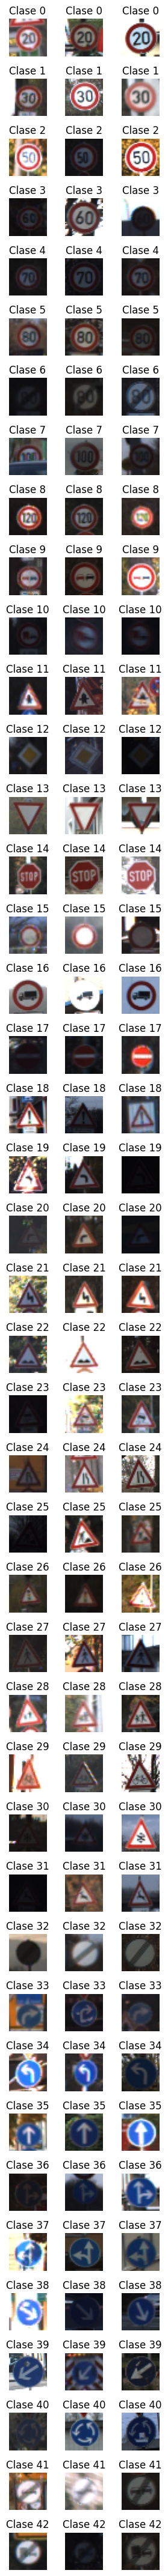

In [9]:
num_samples_class = 3

plt.figure(figsize=(num_samples_class, 43))

for i in range(num_classes):
    class_samples = np.where(labels == i)[0][:num_samples_class]
    for j, sample_index in enumerate(class_samples):
        plt.subplot(num_classes, num_samples_class, i * num_samples_class + j + 1)
        plt.imshow(images[sample_index])
        plt.title(f"Clase {i}")
        plt.axis("off")

plt.tight_layout()
plt.show()

<p align="justify">
Podemos comprobar la presencia de cierto ruido en nuestras imágenes, como problemas de iluminación, baja calidad de la imagen, distorsión, entre otros. Este ruido puede afectar negativamente la calidad de las predicciones de nuestra red neuronal convolucional.

Vamos ha comprobar si hay imágenes sin etiquetas:

In [10]:
non_label = np.where(np.isnan(labels))[0]
if len(non_label) > 0:
    print(f"Hay {len(non_label)} imágenes sin etiquetas.")
else:
    print("No hay imágenes sin etiquetas.")

No hay imágenes sin etiquetas.


## Preprocesamiento de los datos

<p align="justify">
Hemos observado previamente que la cantidad de muestras en nuestra red es limitada en relación con la cantidad requerida. Además, estas muestras no están distribuidas uniformemente. Por lo tanto, aplicaremos <i>Data Augmentation</i>.
Debemos tener precaución al seleccionar los rangos de los ángulos de rotación, ya que podrían causar confusiones en nuestra red neuronal mientras estudia señales de tráfico. Generaremos imágenes adicionales hasta alcanzar un total de 5000 en cada clase:

In [11]:
# Crea un generador de imágenes con aumento de datos
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Aplica aumento de datos a las clases con menos muestras
images_aumented = []
labels_aumented = []

for i in range(num_classes):
    class_samples = np.where(labels == i)[0]
    samples_needed = 5000 - len(class_samples)  # Ajusta el número deseado de muestras por clase

    if samples_needed > 0:
        # Seleccionar imágenes aleatorias de la clase actual y aplicar aumento de datos
        random_indices = np.random.choice(class_samples, size=samples_needed, replace=True)
        for idx in random_indices:
            augmented_image = datagen.random_transform(images[idx])  # Utiliza las imágenes originales
            images_aumented.append(augmented_image)
            labels_aumented.append(i)

images_aumented = np.concatenate((images, images_aumented), axis=0)
labels_aumented = np.concatenate((labels, labels_aumented), axis=0)

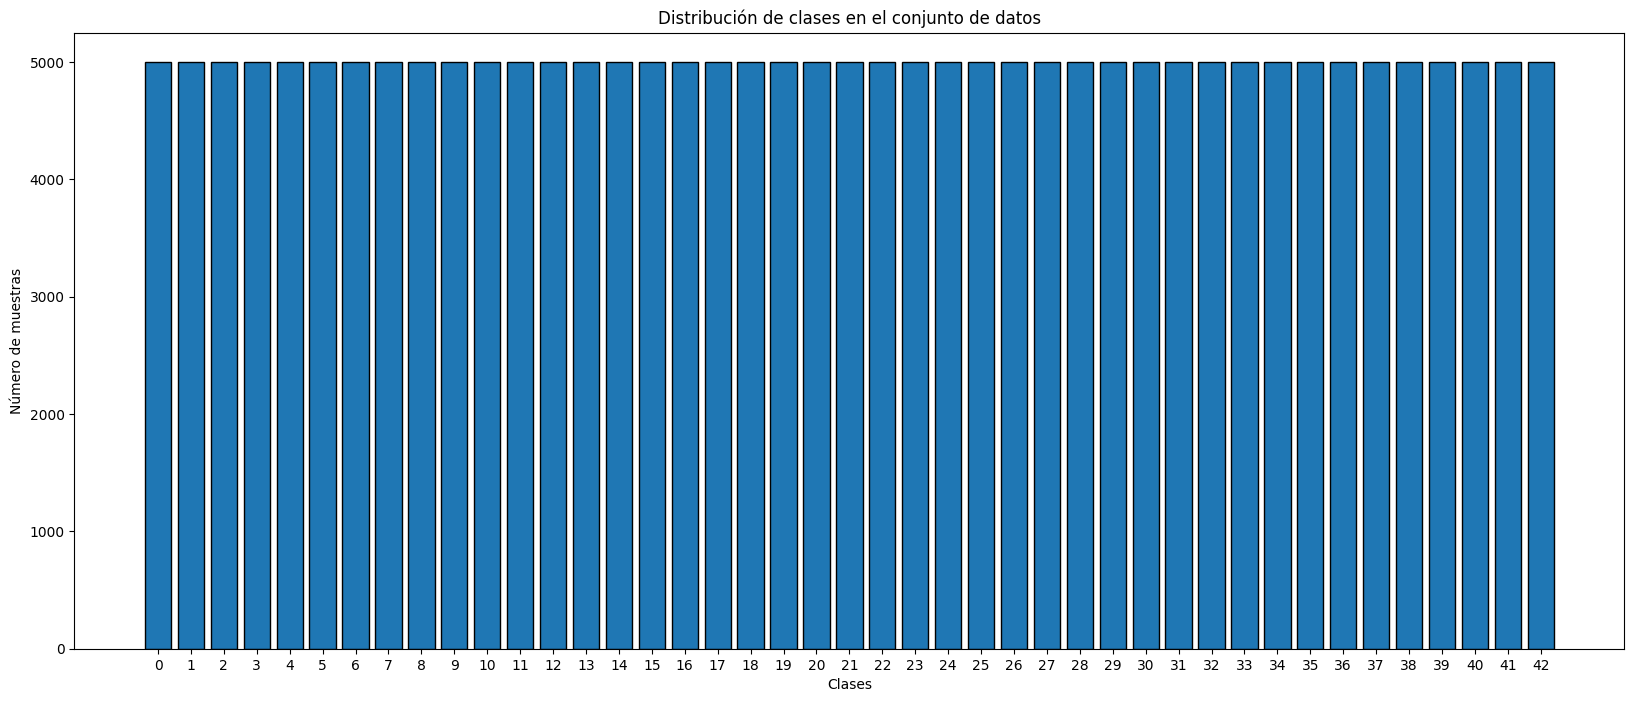

In [12]:
plt.figure(figsize=(20, 8))
plt.hist(labels_aumented, bins=np.arange(num_classes + 1), rwidth=0.8, align='left', edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de datos')
plt.show()

<p align="justify">
Vamos a convertir nuestras imágenes a escala de grises. Hemos observado previamente que el color de las señales no marca la diferencia entre ellas, sino que lo hacen la forma y la figura. Al obviar el color, contribuimos a un mejor aprendizaje de nuestra red, facilitando así la convergencia:

In [13]:
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

images_aumented_gray = np.asarray([gray_scale(image) for image in images_aumented])

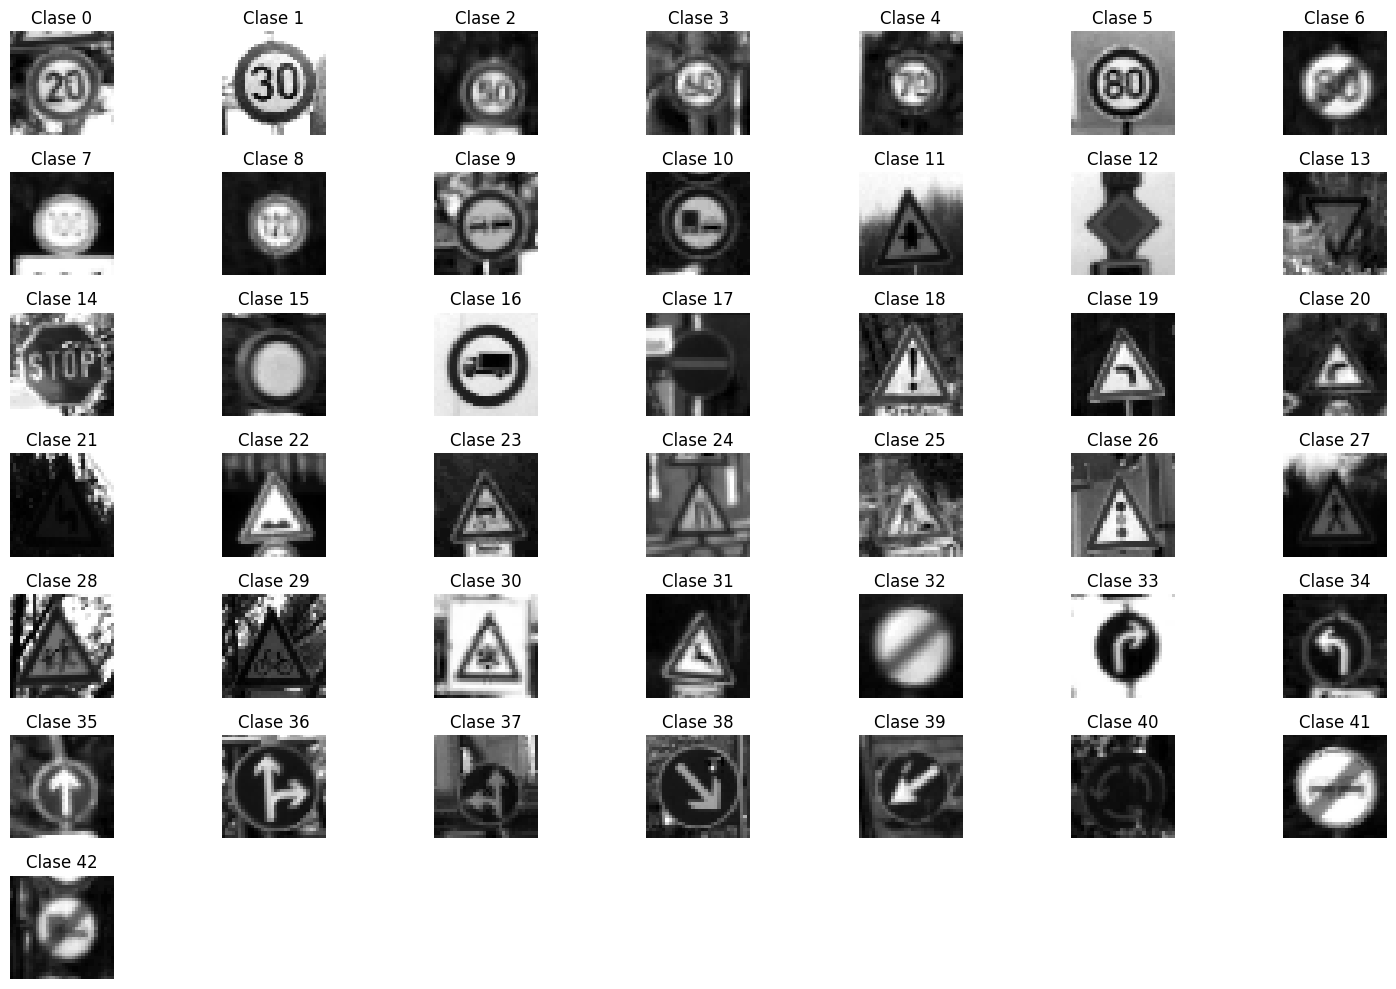

In [14]:
random.seed(42)
np.random.seed(42)
sample_images = []
for i in range(num_classes):
    class_samples = np.where(labels == i)[0]
    sample_image_index = random.choice(class_samples)
    sample_image = images_aumented_gray[sample_image_index]
    sample_images.append(sample_image)

# Crear el mosaico
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    plt.subplot(mosaic_rows, mosaic_cols, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Clase {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

<p align="justify">
Dado que nuestras imágenes están en escala de grises, ajustamos su contraste utilizando el ecualizador de histograma. De esta manera, logramos que la red sea capaz de percibir con mayor precisión los detalles al realzar el contraste:

In [15]:
def local_histo_equalize(image):
    # Definir un kernel (estructurante) en forma de disco
    kernel = morp.disk(35)

    # Aplicar la ecualización del histograma local utilizando el kernel definido
    img_local = rank.equalize(image, selem=kernel)

    # Devolver la imagen después de la ecualización del histograma local
    return img_local

images_aumented_gray_equal = np.asarray([local_histo_equalize(image) for image in images_aumented_gray])
images_aumented_gray_equal = np.expand_dims(images_aumented_gray_equal, axis=-1)

<ipython-input-15-aa4acc34dc77>:6: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  img_local = rank.equalize(image, selem=kernel)


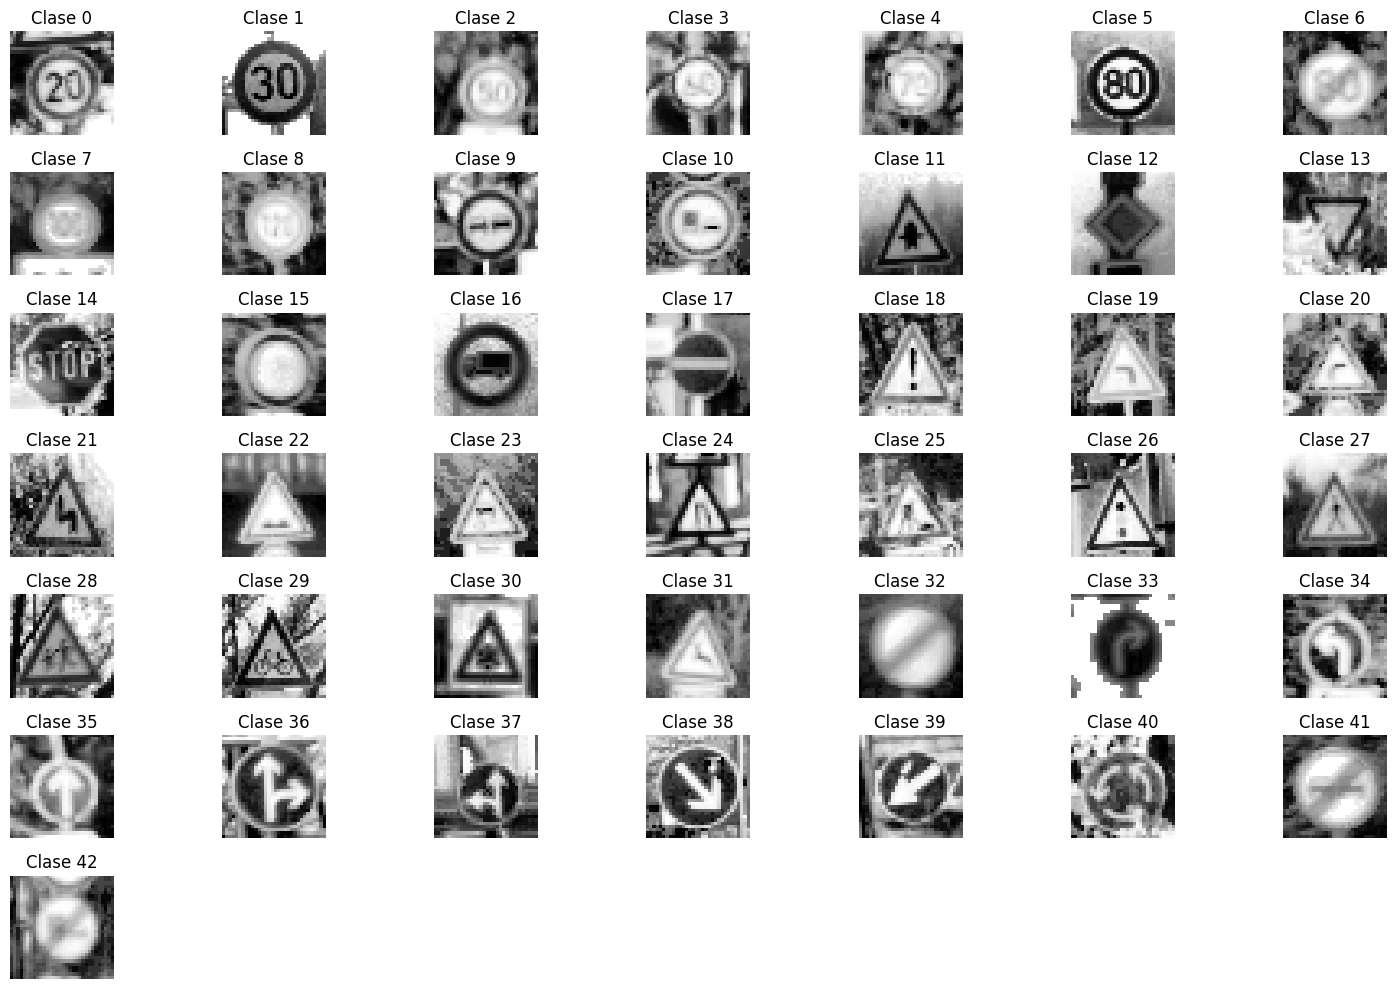

In [16]:
random.seed(42)
np.random.seed(42)
sample_images_equalized = []
for i in range(num_classes):
    class_samples = np.where(labels == i)[0]
    sample_image_index = random.choice(class_samples)
    sample_image_equalized = images_aumented_gray_equal[sample_image_index]
    sample_images_equalized.append(sample_image_equalized)

# Crear el mosaico
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    plt.subplot(mosaic_rows, mosaic_cols, i + 1)
    plt.imshow(sample_images_equalized[i][:, :, 0], cmap='gray')
    plt.title(f"Clase {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

A continuación, dividimos nuestro dataset en datos de test, de entrenamiento y de validación:

In [17]:
x_train, x_temp, y_train, y_temp = train_test_split(images_aumented_gray_equal, labels_aumented, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Normalizamos:

In [18]:
x_train = np.asarray(x_train, dtype = "float32")/255
y_train = np.asarray(y_train, dtype = "float32")

In [19]:
x_test = np.asarray(x_test, dtype = "float32")/255
y_test = np.asarray(y_test, dtype = "float32")

In [20]:
x_val = np.asarray(x_val, dtype = "float32")/255
y_val = np.asarray(y_val, dtype = "float32")

## Red neuronal

In [21]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = "Same", activation = "relu", input_shape = (32,32,1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = "Same", activation = "relu" ))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = "Same", activation = "relu" ))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = num_classes, activation = "softmax"))

Hemos escogido el optimizador Adam porque es el que mejor rendimiento presenta:

In [22]:
# Compilar el modelo con el nuevo optimizador
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Ajustar el modelo al conjunto de entrenamiento
history = model.fit(x_train, y_train, epochs= 28 , validation_data=(x_val, y_val), batch_size=32)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)

Epoch 1/28
4032/4032 [==============================] - 731s 181ms/step - loss: 1.3716 - accuracy: 0.5715 - val_loss: 0.5077 - val_accuracy: 0.8238
Epoch 2/28
4032/4032 [==============================] - 721s 179ms/step - loss: 0.4866 - accuracy: 0.8292 - val_loss: 0.3230 - val_accuracy: 0.8880
Epoch 3/28
4032/4032 [==============================] - 685s 170ms/step - loss: 0.3521 - accuracy: 0.8761 - val_loss: 0.2702 - val_accuracy: 0.9056
Epoch 4/28
4032/4032 [==============================] - 721s 179ms/step - loss: 0.2939 - accuracy: 0.8963 - val_loss: 0.2340 - val_accuracy: 0.9170
Epoch 5/28
4032/4032 [==============================] - 711s 176ms/step - loss: 0.2566 - accuracy: 0.9094 - val_loss: 0.1966 - val_accuracy: 0.9298
Epoch 6/28
4032/4032 [==============================] - 711s 176ms/step - loss: 0.2359 - accuracy: 0.9165 - val_loss: 0.2041 - val_accuracy: 0.9304
Epoch 7/28
4032/4032 [==============================] - 711s 176ms/step - loss: 0.2181 - accuracy: 0.9243 - val_

Vamos a comprobar con las gráficas de pérdida y de precisión si nuestra red está sobreentrenando empleando los datos obtenidos de la validación.

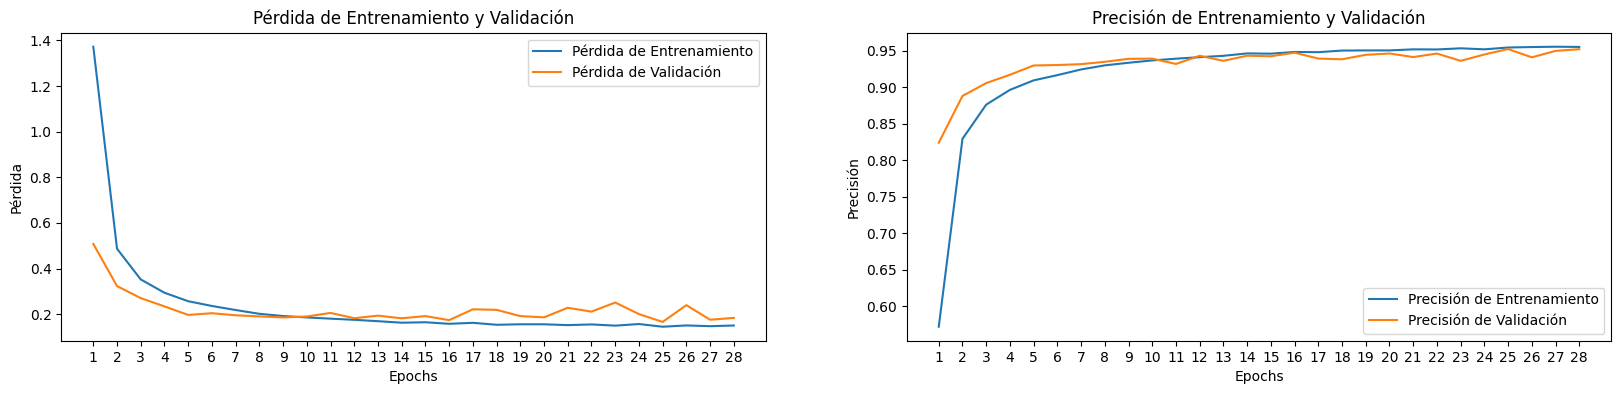

In [30]:
# Graficar la pérdida
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))

# Graficar el accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()
plt.xticks(range(0, len(history.history['accuracy'])), range(1, len(history.history['accuracy']) + 1))

plt.show()

## Resultados de nuestra red

In [24]:
print(f"Nuestra red tiene una precisión de {test_accuracy * 100} %")

Nuestra red tiene una precisión de 95.29069662094116 %


La matriz de confusión es:

1344/1344 [==============================] - 51s 38ms/step


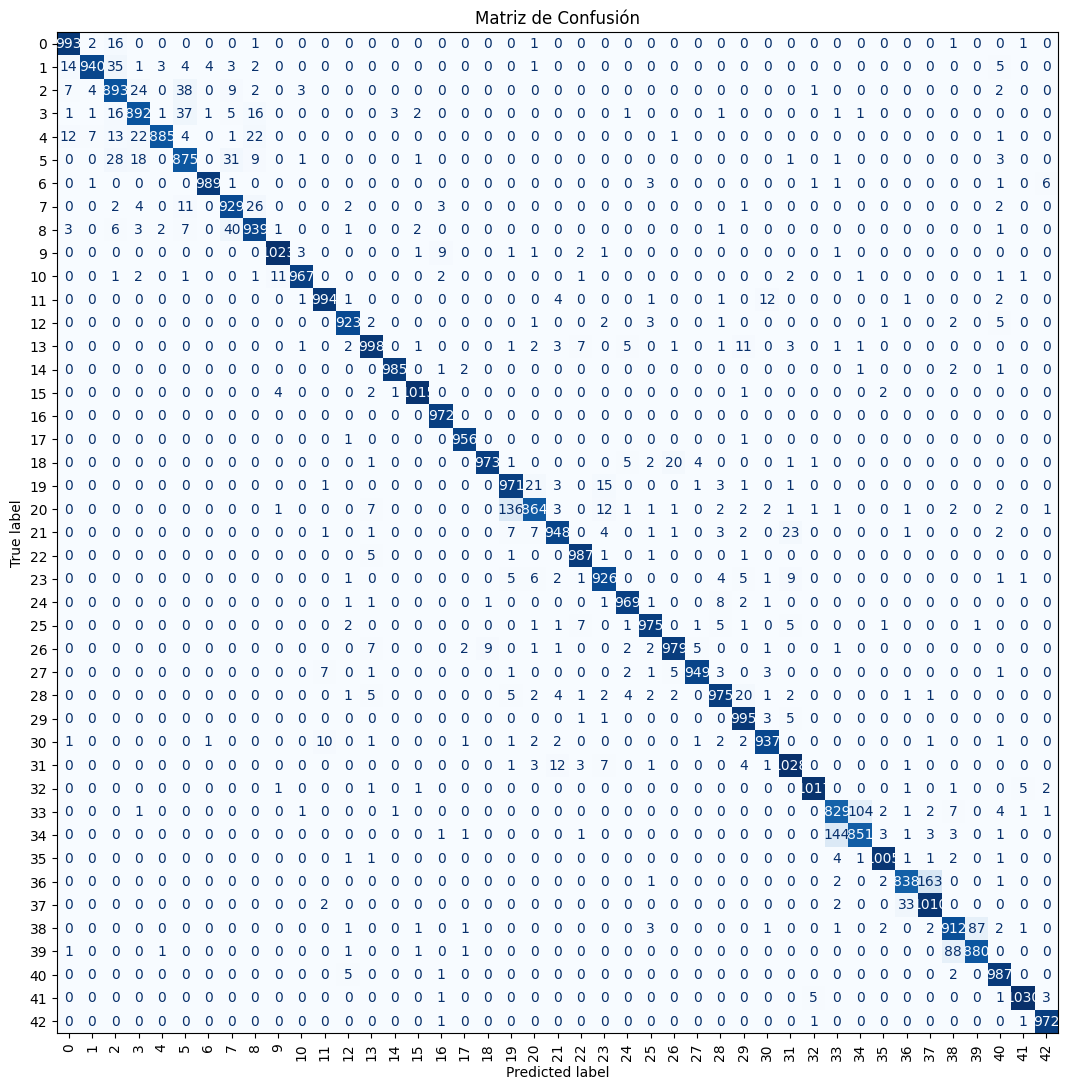

In [25]:
y_pred_prob = model.predict(x_test)
# Tomar la clase con el valor máximo para cada instancia
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=range(num_classes))

plt.figure(figsize=(13, 13))

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca(), xticks_rotation='vertical', colorbar=False)
plt.title('Matriz de Confusión')

plt.show()

La siguiente gráfica muestra los aciertos y los fallos de las predicciones de nuestra red por clase en el conjunto de test:

1344/1344 [==============================] - 53s 40ms/step


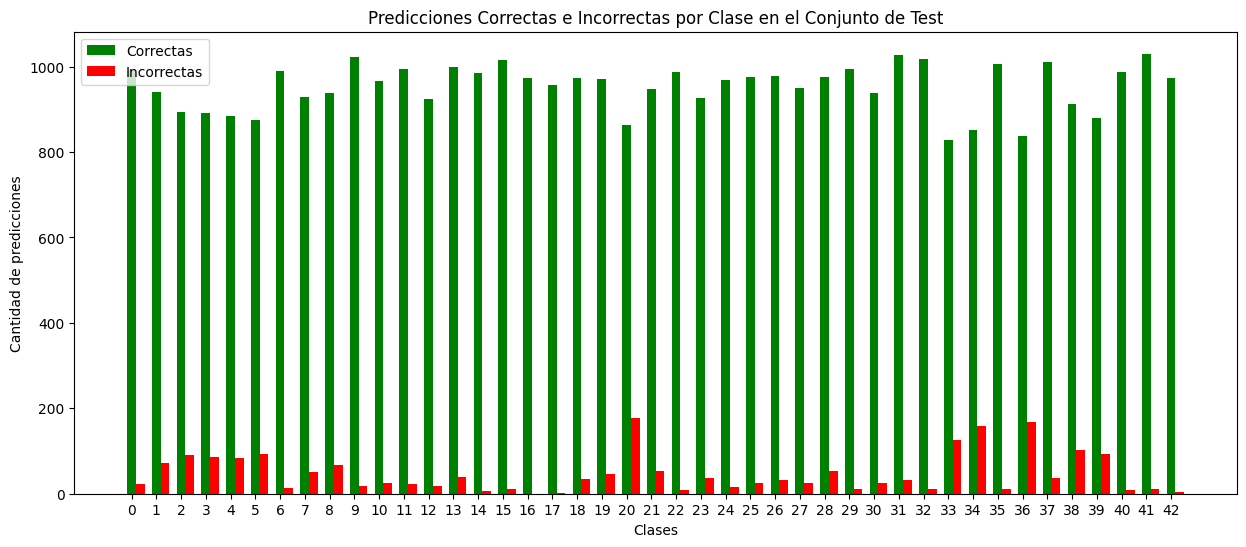

In [26]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convertir las etiquetas a tipo entero
y_test_int = y_test.astype(int)

# Comparar las predicciones con las etiquetas reales
correct_predictions = predicted_labels == y_test_int
incorrect_predictions = ~correct_predictions

# Contar la cantidad de predicciones correctas e incorrectas por clase
correct_counts = np.bincount(y_test_int[correct_predictions], minlength=num_classes)
incorrect_counts = np.bincount(y_test_int[incorrect_predictions], minlength=num_classes)

# Crear la gráfica de barras
plt.figure(figsize=(15, 6))
bar_width = 0.35
index = np.arange(num_classes)

plt.bar(index, correct_counts, bar_width, label='Correctas', color='green', align='edge')
plt.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrectas', color='red', align='edge')

plt.xlabel('Clases')
plt.ylabel('Cantidad de predicciones')
plt.title('Predicciones Correctas e Incorrectas por Clase en el Conjunto de Test')
plt.xticks(index + bar_width / 2, range(num_classes))
plt.legend()
plt.show()


<p align="justify">
Las siguientes gráficas muestran la contribución de cada clase a la precisión y a la pérdida de nuestra red:

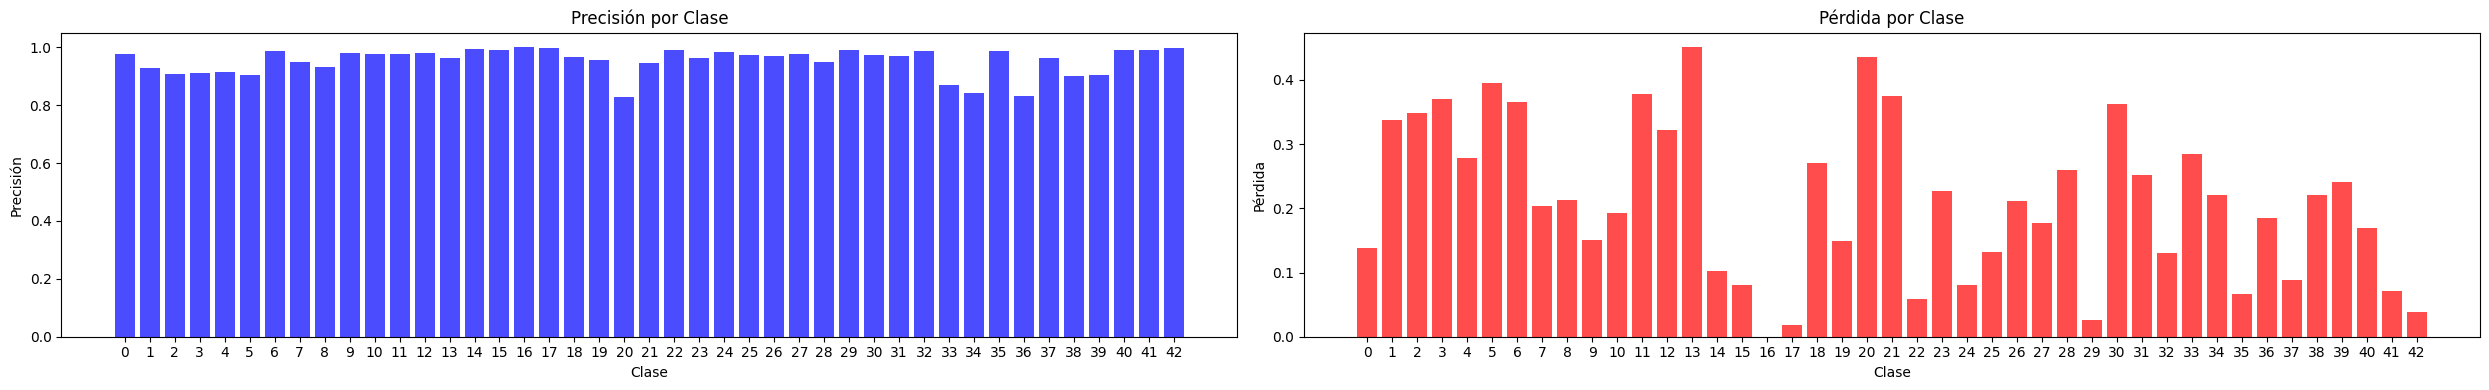

In [27]:
# Calcular precisión y pérdida por clase
class_accuracy = np.sum((predicted_labels == y_test_int) & (y_test_int == np.arange(num_classes)[:, None]), axis=1) / np.sum(y_test_int == np.arange(num_classes)[:, None], axis=1)
class_loss = np.bincount(y_test_int, weights=np.abs(predicted_labels - y_test_int), minlength=num_classes) / np.bincount(y_test_int, minlength=num_classes)

# Visualizar la precisión y pérdida por clase
plt.figure(figsize=(25, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.bar(range(num_classes), class_accuracy, color='blue', alpha=0.7)
plt.title('Precisión por Clase')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.xticks(range(num_classes))

# Pérdida
plt.subplot(1, 2, 2)
plt.bar(range(num_classes), class_loss, color='red', alpha=0.7)
plt.title('Pérdida por Clase')
plt.xlabel('Clase')
plt.ylabel('Pérdida')
plt.xticks(range(num_classes))

plt.tight_layout()
plt.show()


## Conclusión

<p align="justify">
Nuestra red logra una tasa de precisión del $95.29 \%$, un valor muy positivo si consideramos que el modelo base a superar consistía en seleccionar una de las clases de manera aleatoria, es decir, $\frac{1}{43} \cdot 100 \approx 2.33\%$.
</p>
<p align="justify">
Al observar las gráficas previamente mostradas, notamos que las clases más desafiantes de clasificar son aquellas cuyas señales están compuestas por flechas. Esto podría deberse a la sensibilidad de la red neuronal ante las rotaciones que aplicamos a las imágenes para generar nuevas muestras. Dado que estas señales son figuras geométricas simples, su clasificación depende en gran medida de la orientación.
</p>
